In [1]:
# import warnings
# warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
print('pytorch version:', torch.__version__)
global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', global_device)
from torch.utils.data import DataLoader, random_split, Dataset

import random

import pytorch_lightning as pl
import pytorchltr as pltr

from pytorchltr.evaluation import ndcg
from pytorchltr.loss import LambdaNDCGLoss2

import neuralndcg
import lambdaloss

pytorch version: 2.0.0
Device: cuda:0


In [2]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Data loading

In [3]:
out_dir = './out'

### Preprocessed embeddings:

In [4]:
query_embeddings = np.load(f'{out_dir}/query_embeddings_all-MiniLM-L6-v2.npy')
query_embeddings = np.repeat(query_embeddings, 5, axis=0).reshape([-1, 5, 384])
documents_embeddings = np.load(f'{out_dir}/documents_embeddings_all-MiniLM-L6-v2.npy')
documents_embeddings = documents_embeddings.reshape([-1, 5, 384])

### Preprocessed text features:

In [5]:
features = pd.read_csv(f'{out_dir}/features.csv')
features = features.drop(features.columns[0], axis=1)
features = features.to_numpy().reshape([-1, 5, 15])

### Train & Test -> Dataloaders

In [6]:
train_mask = (np.random.rand(query_embeddings.shape[0]) < 0.8)

query_train = query_embeddings[train_mask]
query_val = query_embeddings[~train_mask]

documents_train = documents_embeddings[train_mask]
documents_val = documents_embeddings[~train_mask]

features_train = features[train_mask]
features_val = features[~train_mask]

relevance_train = np.tile(np.array([4, 3, 2, 1, 0]), (query_train.shape[0], 1))
relevance_val = np.tile(np.array([4, 3, 2, 1, 0]), (query_val.shape[0], 1))

In [7]:
class CommentEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, query, documents, features, relevance):
        assert isinstance(query, torch.Tensor) or isinstance(query, np.ndarray)
        assert isinstance(documents, torch.Tensor) or isinstance(documents, np.ndarray)
        assert isinstance(features, torch.Tensor) or isinstance(features, np.ndarray)
        assert isinstance(relevance, torch.Tensor) or isinstance(relevance, np.ndarray)
        
        assert query.shape[0] == documents.shape[0] == relevance.shape[0] == features.shape[0]
        assert documents.shape[1] == relevance.shape[1] == features.shape[1]
        
        # Real scores as true labels
        self.relevances = torch.FloatTensor(relevance).to(global_device)
        
        # Input vector = concat[query, documents, features, relevance]
        self.x = torch.cat([torch.FloatTensor(query), 
                       torch.FloatTensor(documents), 
                       torch.FloatTensor(features)], dim=2).to(global_device)
        print('Shape x:', self.x.shape)
        print('Shape r:', self.relevances.shape)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        x = self.x[idx]
        r = self.relevances[idx]
        return x, r

In [8]:
batch_size = 128

print('Train data shape:')
dataset_train = CommentEmbeddingDataset(query_train, documents_train, features_train, relevance_train)
dataloader_train = DataLoader(dataset_train, batch_size)

print('\nVal data shape:')
dataset_val = CommentEmbeddingDataset(query_val, documents_val, features_val, relevance_val)
dataloader_val = DataLoader(dataset_val, batch_size)

Train data shape:
Shape x: torch.Size([70494, 5, 783])
Shape r: torch.Size([70494, 5])

Val data shape:
Shape x: torch.Size([17613, 5, 783])
Shape r: torch.Size([17613, 5])


In [9]:
# Memory release
del query_embeddings
del documents_embeddings
del features

del query_train
del query_val
del documents_train
del documents_val
del features_train
del features_val
del relevance_train
del relevance_val

del dataset_train
del dataset_val

In [10]:
class FeatureToScore(pl.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        
        self.input_dim = input_dim
        
        self.linear_block_1 = nn.Sequential(torch.nn.Linear(self.input_dim, self.input_dim),
                                            torch.nn.LeakyReLU())
        self.linear_block_1_1 = nn.Sequential(torch.nn.Linear(self.input_dim, self.input_dim),
                                            torch.nn.LeakyReLU())
        self.linear_block_1_2 = nn.Sequential(torch.nn.Linear(self.input_dim, self.input_dim),
                                            torch.nn.LeakyReLU())
        self.linear_block_2 = nn.Sequential(torch.nn.Linear(self.input_dim, int(self.input_dim / 2)),
                                            torch.nn.LeakyReLU())
        self.linear_block_3 = nn.Sequential(torch.nn.Linear(int(self.input_dim / 2), int(self.input_dim / 4)),
                                            torch.nn.LeakyReLU())
        self.linear_block_out = nn.Sequential(torch.nn.Linear(int(self.input_dim / 4), 1))

        self.n_docs_per_query = torch.tensor([5]).to(global_device)
        
        
    def forward(self, x):
        o_1 = self.linear_block_1(x)
#         o_1_1 = self.linear_block_1_1(o_1)
#         o_1_2 = self.linear_block_1_2(o_1_1)
        o_2 = self.linear_block_2(o_1)
        o_3 = self.linear_block_3(o_2)
        o_out = self.linear_block_out(o_3)
        return o_out

    def training_step(self, batch, batch_idx):
        x, r = batch
        x.reshape(-1, x.shape[-1])
        scores = self(x)
        scores = scores.reshape(-1, self.n_docs_per_query[0])
        loss = lambdaloss.lambdaLoss(scores, r, reduction='mean')
        self.log("train_loss", loss, prog_bar=True)
        
        train_ndcg = pltr.evaluation.ndcg(scores, r, self.n_docs_per_query, k=self.n_docs_per_query[0]).mean()
        self.log("train_ndcg", train_ndcg, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, r = batch
        x.reshape(-1, x.shape[-1])
        scores = self(x)
        scores = scores.reshape(-1, self.n_docs_per_query[0])
        
        val_ndcg = pltr.evaluation.ndcg(scores, r, self.n_docs_per_query, k=self.n_docs_per_query[0]).mean()
        self.log("val_ndcg", val_ndcg, prog_bar=True)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.75)
        
        return {"optimizer": optimizer,
                "lr_scheduler": {
                                "scheduler": scheduler,
                                "interval": "epoch",
                                "frequency": 1
                                },
               }

In [11]:
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, max_epochs=15)
model = FeatureToScore(783)
trainer.fit(model, dataloader_train, dataloader_val, )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Arseny\AppData\Local\miniconda3\envs\venv_ml\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_p

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Arseny\AppData\Local\miniconda3\envs\venv_ml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Arseny\AppData\Local\miniconda3\envs\venv_ml\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [12]:
df = pd.read_csv('lightning_logs/version_92/metrics.csv')

In [14]:
df

,train_loss,train_ndcg,epoch,step,val_ndcg
0,0.929871,0.819112,0,49,NaN
1,0.903610,0.813864,0,99,NaN
2,0.897367,0.836418,0,149,NaN
3,0.855927,0.843898,0,199,NaN
4,0.838698,0.855957,0,249,NaN
...,...,...,...,...,...
175,0.819270,0.848957,14,8099,NaN
176,0.849919,0.837463,14,8149,NaN
177,0.866864,0.834410,14,8199,NaN
178,0.823436,0.848982,14,8249,NaN


Text(0, 0.5, 'Train Loss')

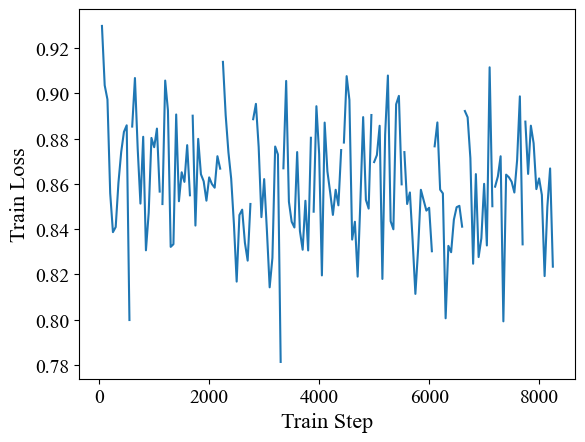

In [17]:
plt.plot(df['step'], df['train_loss'])
plt.xlabel('Train Step')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Val NDCG')

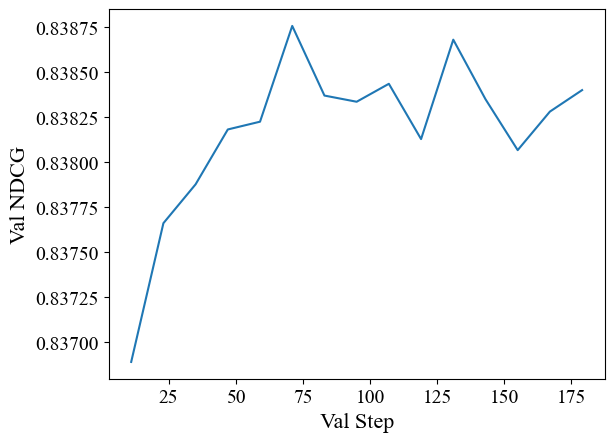

In [19]:
plt.plot(df['val_ndcg'].dropna())
plt.xlabel('Val Step')
plt.ylabel('Val NDCG')

Catboost Ranker provides NDCG=0.89 for validation data (In another .ipynb). Here we see NDCG=0.84, but this is because there are two different ways to calculate NDCG for Catboost and here. We checked the Catboost predicted values with NDCG function from this file and found out that the quality of predictions are equal: (local_NDCG=0.84) == (catboost_NDCG=0.89).
So this model can be use in Stacking with Catboost.